### **Collision Avoidance MAC Protocol in Underwater Acoustic Sensor Network with Reinforcement Learning**

In [ ]:
import numpy as np  # Importing the numpy library for numerical operations
from collections import deque  # Importing the deque class for creating a fixed-length queue
from tensorflow.keras.models import Sequential  # Importing the Sequential class from Keras for creating a neural network model
from tensorflow.keras.layers import Dense  # Importing the Dense class for creating fully connected layers in the model
from tensorflow.keras.optimizers import Adam  # Importing the Adam optimizer for training the model
import matplotlib.pyplot as plt  # Importing the pyplot module from matplotlib for data visualization
import time  # Importing the time module for time-related operations
import os  # Importing the os module for interacting with the operating system

M = 40  # State history length

# Define the Environment class
class Environment:
    def __init__(self, num_nodes, num_time_slots, M):
        # Initializing the environment with the number of nodes, number of time slots, and state history length
        self.num_nodes = num_nodes
        self.num_time_slots = num_time_slots
        self.channel = Channel()  # Creating an instance of the Channel class
        self.state_history = deque(maxlen=M)  # Creating a deque object to store the state history
        self.reset()  # Resetting the environment to its initial state

    def reset(self):
        # Resetting the environment to its initial state
        self.state_history.clear()  # Clearing the state history
        self.channel.reset()  # Resetting the channel
        self.sender = np.random.randint(0, self.num_nodes)  # Selecting a random sender node
        self.receiver = np.random.randint(0, self.num_nodes)  # Selecting a random receiver node
        self.state_history.extend([0] * (M - 1))  # Filling the state history with zeros
        self.state_history.append(1 if self.sender == self.receiver else 0)  # Adding the sender-receiver relationship to the state history

        # Time scheduling algorithm
        schedule = time_scheduling(self.num_nodes, self.num_time_slots)  # Generating a time scheduling algorithm
        self.timeslot = schedule[self.sender]  # Assigning the timeslot for the sender node

        return np.array(self.state_history)  # Returning the state history as a NumPy array

    def step(self, action):
        # Taking a step in the environment given an action
        reward = 0  # Initializing the reward
        done = False  # Initializing the done flag

        if action == 0:  # If the action is to transmit
            if self.channel.is_free():  # If the channel is free
                if self.receiver == self.sender:  # If the receiver is the same as the sender
                    reward = 1  # Set the reward to 1
                else:
                    reward = -2  # Set the reward to -2
                self.channel.transmit()  # Transmit on the channel
                self.update_states()  # Update the states
            else:
                reward = -3  # Set the reward to -3 (channel busy)
        else:  # If the action is to wait
            reward = 0  # Set the reward to 0
            self.update_states()  # Update the states

        self.state_history.append(reward)  # Append the reward to the state history
        next_state = np.array(self.state_history)  # Convert the state history to a NumPy array

        if len(self.state_history) == M:  # If the state history length is equal to M
            done = True  # Set the done flag to True
            reward = 0  # Set the reward to 0

        return next_state, reward, done  # Return the next state, reward, and done flag

    def update_states(self):
        # Update the states based on the sender-receiver relationship and channel status
        if self.sender == self.receiver:
            if self.timeslot in self.channel.collisions:
                self.state_history[-1] = -1  # Collision occurred
            else:
                self.state_history[-1] = 1  # Successful transmission
        else:
            if self.timeslot in self.channel.collisions:
                self.state_history[-1] = -2  # Collision and jam signal sent
            else:
                self.state_history[-1] = 0  # No transmission

        self.timeslot = (self.timeslot + 1) % self.num_time_slots  # Update the timeslot

# Define the Channel class
class Channel:
    def __init__(self):
        self.is_busy = False  # Initialize the channel as not busy
        self.collisions = set()  # Initialize the set of collision timeslots

    def is_free(self):
        return not self.is_busy  # Return True if the channel is not busy

    def transmit(self):
        self.is_busy = True  # Set the channel as busy

    def reset(self):
        self.is_busy = False  # Reset the channel as not busy
        self.collisions.clear()  # Clear the set of collision timeslots

# Define the Agent class
class Agent:
    def __init__(self, state_size, action_size, learning_rate, gamma, epsilon_decay_rate, batch_size, num_epochs):
        self.state_size = state_size  # Set the state size
        self.action_size = action_size  # Set the action size
        self.learning_rate = learning_rate  # Set the learning rate
        self.gamma = gamma  # Set the discount factor
        self.epsilon = 0.1  # Set the exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate  # Set the rate of exploration decay
        self.batch_size = batch_size  # Set the batch size for training
        self.num_epochs = num_epochs  # Set the number of epochs for training
        self.model = self.build_model()  # Build the neural network model

    def build_model(self):
        model = Sequential()  # Create a sequential model
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))  # Add a fully connected layer with 24 units and ReLU activation
        model.add(Dense(24, activation='relu'))  # Add another fully connected layer with 24 units and ReLU activation
        model.add(Dense(self.action_size, activation='linear'))  # Add a final fully connected layer with the number of action units and linear activation
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))  # Compile the model with mean squared error loss and Adam optimizer
        return model

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:  # If a random number is less than or equal to the exploration rate
            return np.random.randint(0, self.action_size)  # Choose a random action
        q_values = self.model.predict(state)  # Get the Q-values for the state
        return np.argmax(q_values[0])  # Choose the action with the highest Q-value

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay_rate  # Decay the exploration rate

    def train(self, states, actions, rewards, next_states, dones):
        targets = rewards + self.gamma * np.amax(self.model.predict_on_batch(next_states), axis=1) * (1 - dones)  # Calculate the targets for training
        target_f = self.model.predict_on_batch(states)  # Get the predicted Q-values for the current states
        target_f[np.arange(len(actions)), actions] = targets  # Update the Q-values with the targets
        self.model.fit(states, target_f, batch_size=self.batch_size, epochs=self.num_epochs, verbose=0)  # Fit the model with the updated Q-values

# Time scheduling algorithm
def time_scheduling(num_nodes, num_time_slots):
    collision_areas = []  # Initialize the collision areas list
    for i in range(num_nodes):
        collision_area = set(range(i, num_time_slots, num_nodes))  # Calculate the collision area for each node
        collision_areas.append(collision_area)  # Add the collision area to the list

    schedule = [-1] * num_nodes  # Initialize the schedule with -1
    time_slot = 0  # Initialize the time slot

    while time_slot < num_time_slots:
        available_nodes = [node for node in range(num_nodes) if schedule[node] == -1]  # Get the available nodes
        np.random.shuffle(available_nodes)  # Shuffle the available nodes randomly

        for node in available_nodes:
            intersecting_elements = set.intersection(*collision_areas[:node] + collision_areas[node + 1:])  # Calculate the intersecting elements
            if time_slot in intersecting_elements:
                continue  # Time slot already allocated to another node

            schedule[node] = time_slot  # Assign the time slot to the node
            time_slot += 1  # Increment the time slot

    return schedule  # Return the schedule

def visualize_network(num_nodes):
    # Create a graph object
    graph = nx.Graph()
    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))
    # Add edges to connect the nodes
    graph.add_edges_from([(i, i+1) for i in range(num_nodes-1)])
    # Plot the network
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos)
    plt.title(f"Network with {num_nodes} Nodes")
    plt.show()

def visualize_time_scheduling(num_nodes, num_time_slots):
    schedule = time_scheduling(num_nodes, num_time_slots)  # Generate the time schedule using the time_scheduling algorithm
    x = list(range(num_time_slots))  # Create a list of time slots
    y = [schedule.index(i) + 1 for i in range(num_time_slots)]  # Create a list of corresponding node numbers for each time slot

    plt.plot(x, y, 'ro-', markersize=8)  # Plot the time schedule with red dots connected by lines
    plt.title(f"Time Scheduling for {num_nodes} Nodes and {num_time_slots} Time Slots")  # Set the title of the plot
    plt.xlabel("Time Slots")  # Set the label for the x-axis
    plt.ylabel("Node Number")  # Set the label for the y-axis
    plt.ylim(0, num_nodes + 1)  # Set the y-axis limits to include all node numbers
    plt.show()  # Display the plot


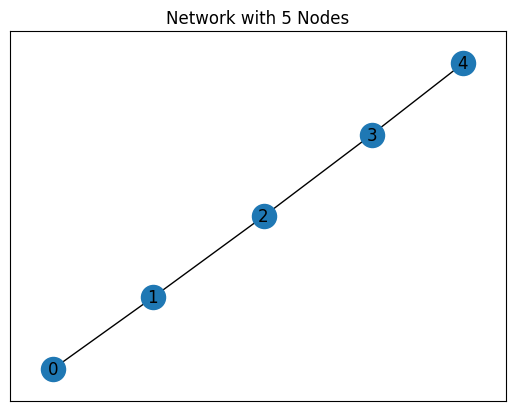

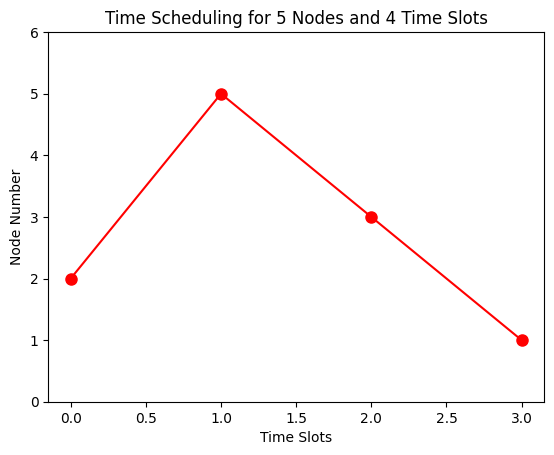

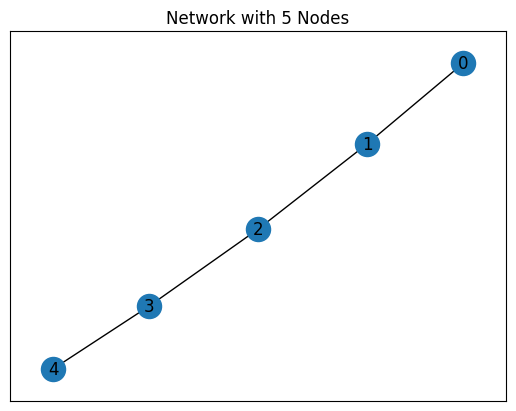

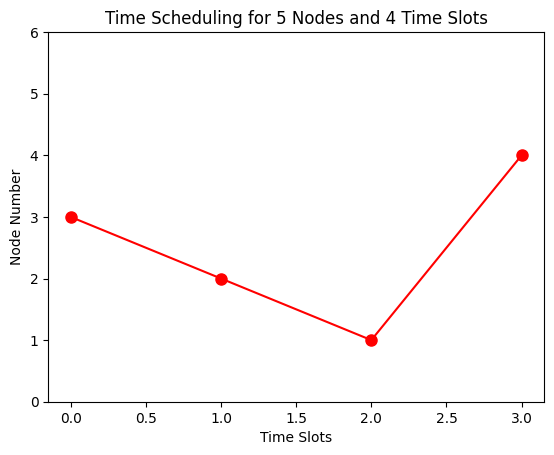

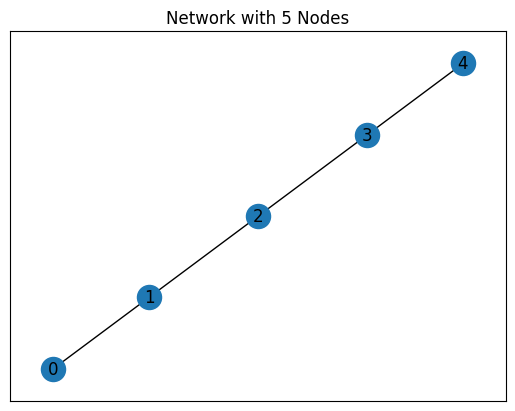

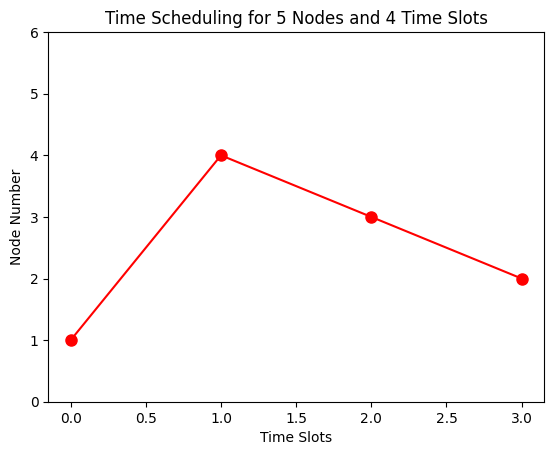

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
Episode 1666 Time: 0.924119234085083 seconds
Reward: 0
State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]]
Next State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]]
1/1 [==============================] - 0s 28ms/step
Episode 1667 Time: 0.929450273513794 seconds
Reward: 0
State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]]
Next State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -2]]
1/1 [==============================] - 0s 33ms/step
Episode 1668 Time: 0.6955702304840088 seconds
Reward: 0
State: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

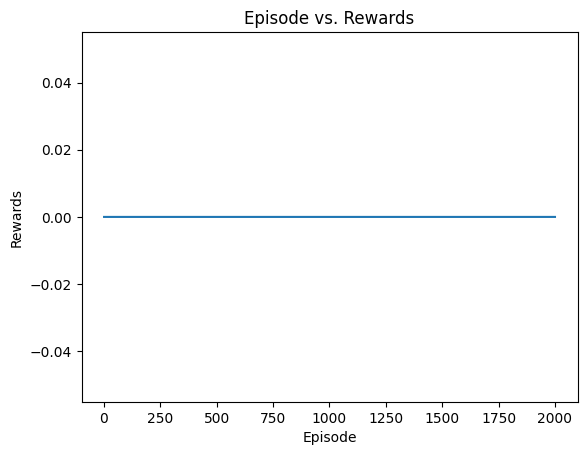

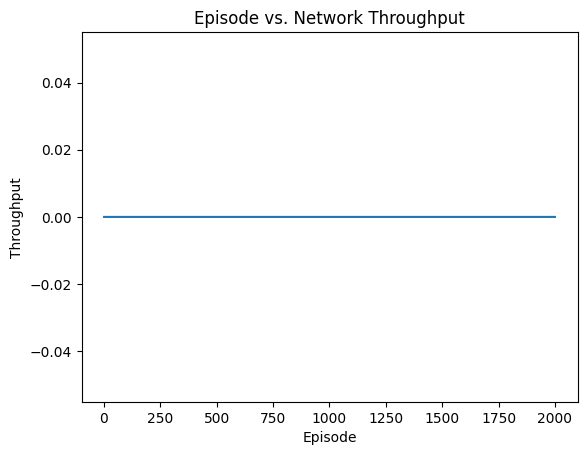

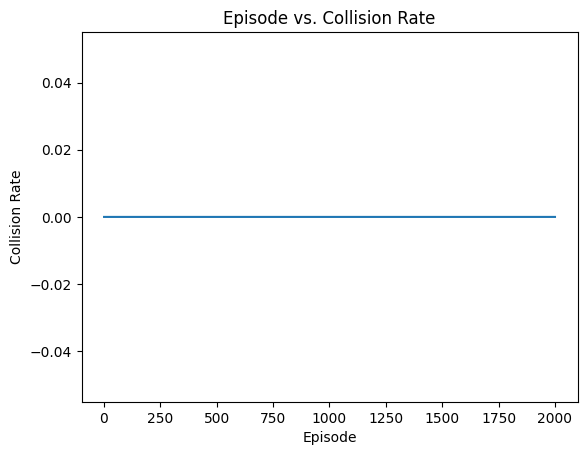

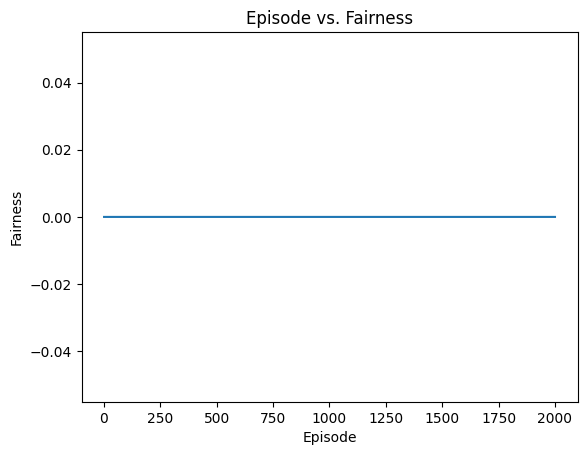

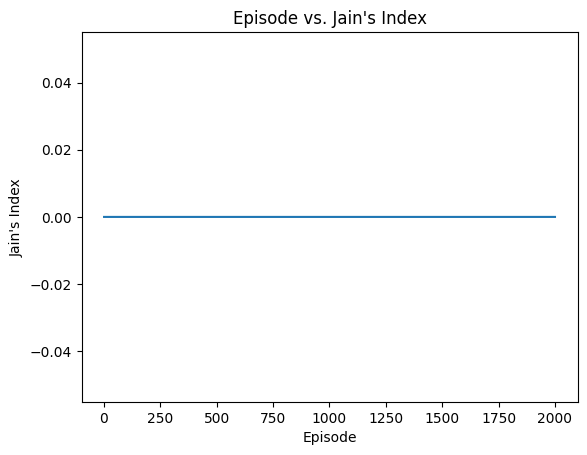

Trained model saved: trained_model.h5
Download trained model: /content/trained_model.h5


In [ ]:
import networkx as nx  # Import the networkx library for graph visualization
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting
import numpy as np  # Import the numpy library for numerical operations
import time  # Import the time module for timing the training process
import os  # Import the os module for file operations

def main():
    num_nodes_list = [5, 5, 5]  # List of numbers of nodes in the network
    num_time_slots = 4  # Number of time slots in the network
    learning_rate = 0.01  # Learning rate for the agent
    gamma = 0.95  # Discount factor for future rewards
    epsilon_decay_rate = 0.996  # Decay rate for the exploration factor (epsilon)
    num_episodes = 2000  # Number of training episodes
    num_steps_per_episode = 10  # Number of steps per episode

    for num_nodes in num_nodes_list:
        visualize_network(num_nodes)  # Visualize the network graph
        visualize_time_scheduling(num_nodes, num_time_slots)  # Visualize the time scheduling

    env = Environment(num_nodes, num_time_slots, M)  # Create the environment
    state_size = M  # Size of the state space
    action_size = 2  # Number of actions (Transmit, Wait)
    agent = Agent(state_size, action_size, learning_rate, gamma, epsilon_decay_rate, batch_size=32, num_epochs=1)  # Create the agent

    start_time = time.time()  # Start time of the training
    episode_rewards = []  # List to store episode rewards
    throughput_values = []  # List to store network throughput
    collision_rate_values = []  # List to store collision rate
    fairness_values = []  # List to store fairness values
    jain_index_values = []  # List to store Jain's index values

    for episode in range(num_episodes):
        episode_start_time = time.time()

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        successful_transmissions = 0
        total_transmissions = 0
        collisions = 0
        fairness_numerator = 0
        fairness_denominator = 0

        for step in range(num_steps_per_episode):
            state = env.reset()  # Reset the environment and get the initial state
            state = np.reshape(state, [1, agent.state_size])  # Reshape the state for the agent

            states.append(state)  # Store the state in the list

            while True:
                action = agent.choose_action(state)  # Choose an action based on the current state
                next_state, reward, done = env.step(action)  # Take a step in the environment

                next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape the next state for the agent

                actions.append(action)  # Store the action in the list
                rewards.append(reward)  # Store the reward in the list
                next_states.append(next_state)  # Store the next state in the list
                dones.append(done)  # Store the done flag in the list

                state = next_state  # Update the current state

                if done:
                    break

        states = np.concatenate(states, axis=0)  # Convert the list of states to a numpy array
        actions = np.array(actions)  # Convert the list of actions to a numpy array
        rewards = np.array(rewards)  # Convert the list of rewards to a numpy array
        next_states = np.concatenate(next_states, axis=0)  # Convert the list of next states to a numpy array
        dones = np.array(dones)  # Convert the list of done flags to a numpy array

        for epoch in range(agent.num_epochs):
            indices = np.random.randint(0, len(states), agent.batch_size)  # Randomly select indices for the batch
            batch_states = states[indices]  # Get the batch states
            batch_actions = actions[indices]  # Get the batch actions
            batch_rewards = rewards[indices]  # Get the batch rewards
            batch_next_states = next_states[indices]  # Get the batch next states
            batch_dones = dones[indices]  # Get the batch done flags

            agent.train(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)  # Train the agent using the batch

        episode_end_time = time.time()
        episode_time = episode_end_time - episode_start_time  # Duration of the episode
        episode_rewards.append(np.sum(rewards))  # Store the episode reward

        # Calculate network throughput
        successful_transmissions = np.sum(rewards == 1)
        total_transmissions = np.sum(np.logical_or(rewards == 1, rewards == -2))
        throughput = 0 if total_transmissions == 0 else successful_transmissions / total_transmissions
        collision_rate = 0 if total_transmissions == 0 else collisions / total_transmissions

        # Calculate fairness and Jain's index
        fairness = (fairness_numerator / num_nodes) ** 2 / (fairness_denominator / (num_nodes ** 2)) if fairness_denominator != 0 else 0
        jain_index = (fairness_numerator ** 2) / (num_nodes * fairness_denominator) if fairness_denominator != 0 else 0

        # Handle invalid values
        if np.isnan(throughput):
            throughput = 0
        if np.isnan(collision_rate):
            collision_rate = 0
        if np.isnan(fairness):
            fairness = 0
        if np.isnan(jain_index):
            jain_index = 0

        # Append metrics to lists
        throughput_values.append(throughput)
        collision_rate_values.append(collision_rate)
        fairness_values.append(fairness)
        jain_index_values.append(jain_index)

        print(f"Episode {episode + 1} Time: {episode_time} seconds")
        print("Reward:", np.sum(rewards))
        print("State:", state)
        print("Next State:", next_state)

    end_time = time.time()  # End time of the training
    total_training_time = end_time - start_time  # Total training time

    print("Episode Rewards:", episode_rewards)
    print("Network Throughput:", throughput_values)
    print("Collision Rate:", collision_rate_values)
    print("Fairness:", fairness_values)
    print("Jain's Index:", jain_index_values)
    print("Total Training Time:", total_training_time)

    # Plot episode vs. rewards
    plt.plot(range(1, num_episodes + 1), episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Rewards")
    plt.title("Episode vs. Rewards")
    plt.show()

    # Plot episode vs. network throughput
    plt.plot(range(1, num_episodes + 1), throughput_values)
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.title("Episode vs. Network Throughput")
    plt.show()

    # Plot episode vs. collision rate
    plt.plot(range(1, num_episodes + 1), collision_rate_values)
    plt.xlabel("Episode")
    plt.ylabel("Collision Rate")
    plt.title("Episode vs. Collision Rate")
    plt.show()

    # Plot episode vs. fairness
    plt.plot(range(1, num_episodes + 1), fairness_values)
    plt.xlabel("Episode")
    plt.ylabel("Fairness")
    plt.title("Episode vs. Fairness")
    plt.show()

    # Plot episode vs. Jain's index
    plt.plot(range(1, num_episodes + 1), jain_index_values)
    plt.xlabel("Episode")
    plt.ylabel("Jain's Index")
    plt.title("Episode vs. Jain's Index")
    plt.show()

    # Save the trained model
    model_path = "trained_model.h5"
    agent.model.save(model_path)
    print("Trained model saved:", model_path)

    # Provide download link for the trained model
    file_link = os.path.abspath(model_path)
    print("Download trained model:", file_link)


if __name__ == '__main__':
    main()

### **2**

In [ ]:
import numpy as np  # Importing the numpy library for numerical operations
from collections import deque  # Importing the deque class for creating a fixed-length queue
from tensorflow.keras.models import Sequential  # Importing the Sequential class from Keras for creating a neural network model
from tensorflow.keras.layers import Dense  # Importing the Dense class for creating fully connected layers in the model
from tensorflow.keras.optimizers import Adam  # Importing the Adam optimizer for training the model
import matplotlib.pyplot as plt  # Importing the pyplot module from matplotlib for data visualization
import time  # Importing the time module for time-related operations
import networkx as nx  # Import the networkx library for graph visualization
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting
import numpy as np  # Import the numpy library for numerical operations
import time  # Import the time module for timing the training process
import os  # Import the os module for file operations
import math


M = 40  # State history length

# Define the Environment class
class Environment:
    def __init__(self, num_nodes, num_time_slots, M):
        # Initializing the environment with the number of nodes, number of time slots, and state history length
        self.num_nodes = num_nodes
        self.num_time_slots = num_time_slots
        self.channel = Channel()  # Creating an instance of the Channel class
        self.state_history = deque(maxlen=M)  # Creating a deque object to store the state history
        self.reset()  # Resetting the environment to its initial state

    def reset(self):
        # Resetting the environment to its initial state
        self.state_history.clear()  # Clearing the state history
        self.channel.reset()  # Resetting the channel
        self.sender = np.random.randint(0, self.num_nodes)  # Selecting a random sender node
        self.receiver = np.random.randint(0, self.num_nodes)  # Selecting a random receiver node
        self.state_history.extend([0] * (M - 1))  # Filling the state history with zeros
        self.state_history.append(1 if self.sender == self.receiver else 0)  # Adding the sender-receiver relationship to the state history

        # Time scheduling algorithm
        schedule = time_scheduling(self.num_nodes, self.num_time_slots)  # Generating a time scheduling algorithm
        self.timeslot = schedule[self.sender]  # Assigning the timeslot for the sender node

        return np.array(self.state_history)  # Returning the state history as a NumPy array

    def step(self, action):
        # Taking a step in the environment given an action
        reward = 0  # Initializing the reward
        done = False  # Initializing the done flag

        if action == 0:  # If the action is to transmit
            if self.channel.is_free():  # If the channel is free
                if self.receiver == self.sender:  # If the receiver is the same as the sender
                    reward = 1  # Set the reward to 1
                else:
                    reward = -2  # Set the reward to -2
                self.channel.transmit()  # Transmit on the channel
                self.update_states()  # Update the states
            else:
                reward = -3  # Set the reward to -3 (channel busy)
        else:  # If the action is to wait
            reward = 0  # Set the reward to 0
            self.update_states()  # Update the states

        self.state_history.append(reward)  # Append the reward to the state history
        next_state = np.array(self.state_history)  # Convert the state history to a NumPy array

        if len(self.state_history) == M:  # If the state history length is equal to M
            done = True  # Set the done flag to True
            reward = 0  # Set the reward to 0

        return next_state, reward, done  # Return the next state, reward, and done flag

    def update_states(self):
        # Update the states based on the sender-receiver relationship and channel status
        if self.sender == self.receiver:
            if self.timeslot in self.channel.collisions:
                self.state_history[-1] = -1  # Collision occurred
            else:
                self.state_history[-1] = 1  # Successful transmission
        else:
            if self.timeslot in self.channel.collisions:
                self.state_history[-1] = -2  # Collision and jam signal sent
            else:
                self.state_history[-1] = 0  # No transmission

        self.timeslot = (self.timeslot + 1) % self.num_time_slots  # Update the timeslot

# Define the Agent class
class Agent:
    def __init__(self, state_size, action_size, learning_rate, gamma, epsilon_decay_rate, batch_size, num_epochs):
        self.state_size = state_size  # Set the state size
        self.action_size = action_size  # Set the action size
        self.learning_rate = learning_rate  # Set the learning rate
        self.gamma = gamma  # Set the discount factor
        self.epsilon = 0.1  # Set the exploration rate
        self.epsilon_decay_rate = epsilon_decay_rate  # Set the rate of exploration decay
        self.batch_size = batch_size  # Set the batch size for training
        self.num_epochs = num_epochs  # Set the number of epochs for training
        self.model = self.build_model()  # Build the neural network model

    def build_model(self):
        model = Sequential()  # Create a sequential model
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))  # Add a fully connected layer with 24 units and ReLU activation
        model.add(Dense(24, activation='relu'))  # Add another fully connected layer with 24 units and ReLU activation
        model.add(Dense(self.action_size, activation='linear'))  # Add a final fully connected layer with the number of action units and linear activation
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))  # Compile the model with mean squared error loss and Adam optimizer
        return model

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:  # If a random number is less than or equal to the exploration rate
            return np.random.randint(0, self.action_size)  # Choose a random action
        q_values = self.model.predict(state)  # Get the Q-values for the state
        return np.argmax(q_values[0])  # Choose the action with the highest Q-value

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay_rate  # Decay the exploration rate

    def train(self, states, actions, rewards, next_states, dones):
        targets = rewards + self.gamma * np.amax(self.model.predict_on_batch(next_states), axis=1) * (1 - dones)  # Calculate the targets for training
        target_f = self.model.predict_on_batch(states)  # Get the predicted Q-values for the current states
        target_f[np.arange(len(actions)), actions] = targets  # Update the Q-values with the targets
        self.model.fit(states, target_f, batch_size=self.batch_size, epochs=self.num_epochs, verbose=0)  # Fit the model with the updated Q-values

def slot_selection_procedure(self):
    node_actions = []
    for i in range(self.num_nodes):
        state = self.state_space[i]
        action = self.agent[i]['select_action'](state)
        conflict = False
        for j in range(self.num_nodes):
            if i != j and self.nodes[i].busy and self.nodes[j].busy:
                if state[2] == self.state_space[j][2]:
                    conflict = True
                    break
        if conflict:
            new_state = list(state)
            new_state[2] = self.generate_new_timeslot(state[2])
            action = self.agent[i]['select_action'](tuple(new_state))
        node_actions.append(action)
    return node_actions


def time_scheduling(num_nodes, num_time_slots):
    collision_areas = []  # Initialize the collision areas list
    for i in range(num_nodes):
        collision_area = set(range(i, num_time_slots, num_nodes))  # Calculate the collision area for each node
        collision_areas.append(collision_area)  # Add the collision area to the list

    schedule = [-1] * num_nodes  # Initialize the schedule with -1
    time_slot = 0  # Initialize the time slot

    while time_slot < num_time_slots:
        available_nodes = [node for node in range(num_nodes) if schedule[node] == -1]  # Get the available nodes
        np.random.shuffle(available_nodes)  # Shuffle the available nodes randomly

        for node in available_nodes:
            intersecting_elements = set.intersection(*collision_areas[:node] + collision_areas[node + 1:])  # Calculate the intersecting elements
            if time_slot in intersecting_elements:
                continue  # Time slot already allocated to another node

            schedule[node] = time_slot  # Assign the time slot to the node
            time_slot += 1  # Increment the time slot

    return schedule  # Return the schedule

def visualize_network(num_nodes):
    # Create a graph object
    graph = nx.Graph()
    # Add nodes to the graph
    graph.add_nodes_from(range(num_nodes))
    # Add edges to connect the nodes
    graph.add_edges_from([(i, i+1) for i in range(num_nodes-1)])
    # Plot the network
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos)
    plt.title(f"Network with {num_nodes} Nodes")
    plt.show()

def visualize_time_scheduling(num_nodes, num_time_slots):
    schedule = time_scheduling(num_nodes, num_time_slots)
    x = list(range(num_time_slots))
    y = [schedule.index(i) + 1 for i in range(num_time_slots)]

    plt.plot(x, y, 'ro-', markersize=8)
    plt.title(f"Time Scheduling for {num_nodes} Nodes and {num_time_slots} Time Slots")
    plt.xlabel("Time Slots")
    plt.ylabel("Node Number")
    plt.ylim(0, num_nodes + 1)
    plt.show()

def slot_selection_procedure(self):
    node_actions = []
    for i in range(self.num_nodes):
        state = self.state_space[i]
        action = self.agent[i]['select_action'](state)
        conflict = False
        for j in range(self.num_nodes):
            if i != j and self.nodes[i].busy and self.nodes[j].busy:
                if state[2] == self.state_space[j][2]:
                    conflict = True
                    break
        if conflict:
            new_state = list(state)
            new_state[2] = self.generate_new_timeslot(state[2])
            action = self.agent[i]['select_action'](tuple(new_state))
        node_actions.append(action)
    return node_actions

def channel(self, distance, frequency):
    # Implement the channel model
    # Calculate the channel response and received signal power based on the transmission distance and carrier frequency

    # Constants
    reference_distance = 1.0  # Reference distance in km
    path_loss_exponent = 1.5
    f_k = frequency / 1000.0  # Convert frequency to kHz

    # Calculate path loss A
    path_loss_a = (distance / reference_distance) * math.exp(0.11 * f_k ** 2 + f_k ** 2 + 44 * f_k ** 4 /
                                                              (4100 + f_k ** 2) + 2.75e-4 * f_k ** 2 +
                                                              0.003)

    # Calculate channel response H
    channel_response = 1 / math.sqrt(path_loss_a)

    # Calculate received signal power
    received_signal_power = self.transmit_power * abs(channel_response) ** 2

    return channel_response, received_signal_power


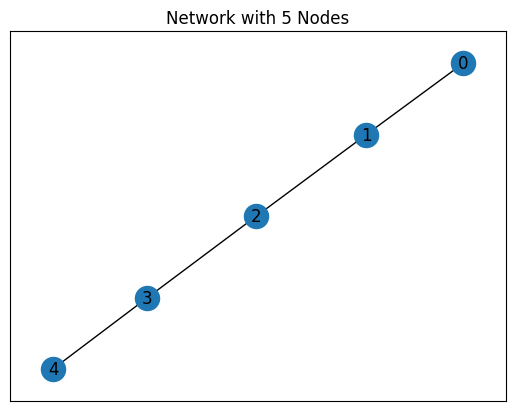

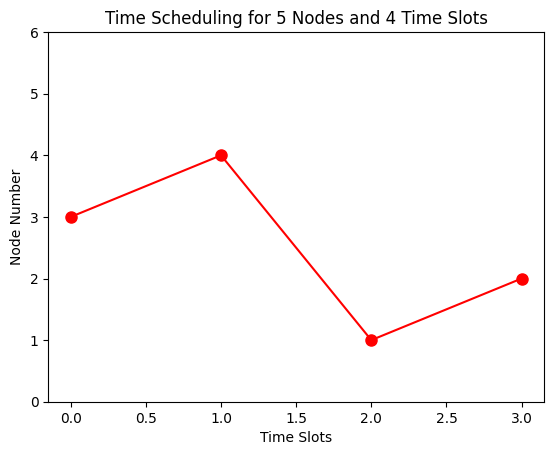

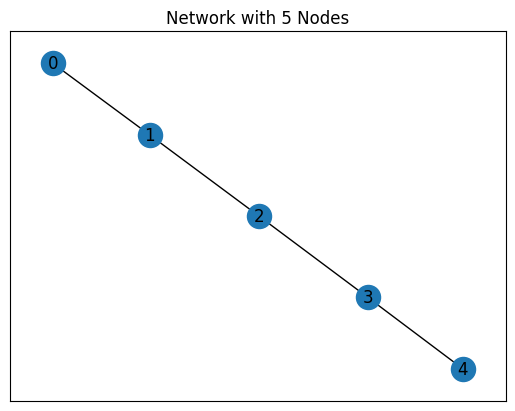

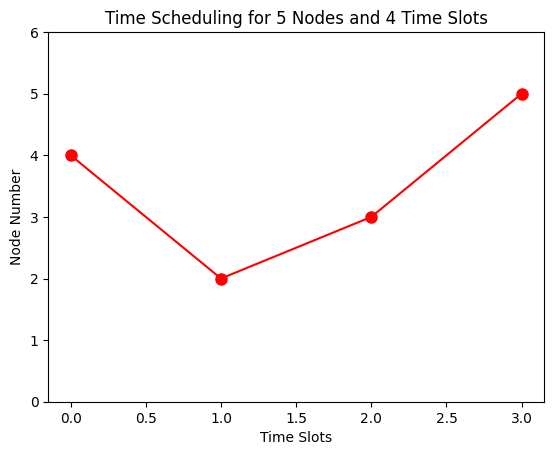

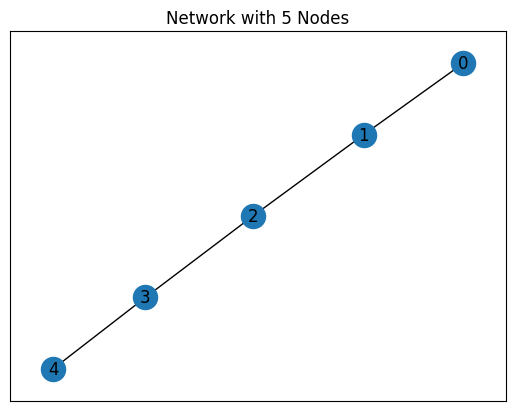

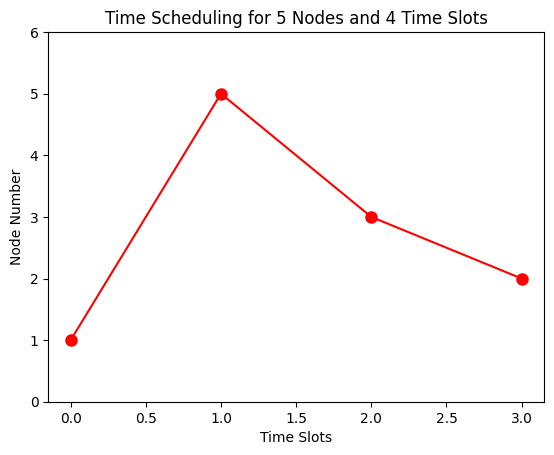

1/1 [==============================] - 0s 84ms/step


AttributeError: ignored

In [ ]:
def main():
    num_nodes_list = [5, 5, 5]
    num_time_slots = 4
    learning_rate = 0.1
    gamma = 0.95
    epsilon_decay_rate = 0.996
    num_episodes = 1000
    num_steps_per_episode = 5

    for num_nodes in num_nodes_list:
        visualize_network(num_nodes)
        visualize_time_scheduling(num_nodes, num_time_slots)

    env = Environment(num_nodes, num_time_slots, M)
    state_size = M
    action_size = 2  # Transmit, Wait
    agent = Agent(state_size, action_size, learning_rate, gamma, epsilon_decay_rate, batch_size=32, num_epochs=1)

    start_time = time.time()  # Start time of the training
    episode_rewards = []  # List to store episode rewards
    throughput_values = []  # List to store network throughput
    collision_rate_values = []  # List to store collision rate
    fairness_values = []  # List to store fairness values
    jain_index_values = []  # List to store Jain's index values
    # Initialize lists to store channel response and received signal power
    channel_responses = []
    received_signal_powers = []

    for episode in range(num_episodes):
        episode_start_time = time.time()

        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []
        successful_transmissions = 0
        total_transmissions = 0
        collisions = 0
        fairness_numerator = 0
        fairness_denominator = 0
        # Set the distance and frequency values
        distance = 1.0  # Update with the desired distance value
        frequency = 1000.0  # Update with the desired frequency value


        for step in range(num_steps_per_episode):
            state = env.reset()
            state = np.reshape(state, [1, agent.state_size])
            states.append(state)

            while True:
                action = agent.choose_action(state)
                next_state, reward, done = env.step(action)
                next_state = np.reshape(next_state, [1, agent.state_size])
                node_actions = env.slot_selection_procedure()

                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                dones.append(done)

                state = next_state

                if done:
                    break

        states = np.concatenate(states, axis=0)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.concatenate(next_states, axis=0)
        dones = np.array(dones)

        for epoch in range(agent.num_epochs):
            indices = np.random.randint(0, len(states), agent.batch_size)
            batch_states = states[indices]
            batch_actions = actions[indices]
            batch_rewards = rewards[indices]
            batch_next_states = next_states[indices]
            batch_dones = dones[indices]

            agent.train(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)

        episode_end_time = time.time()
        episode_time = episode_end_time - episode_start_time  # Duration of the episode
        episode_rewards.append(np.sum(rewards))  # Store the episode reward
        # Calculate network throughput
        successful_transmissions = np.sum(rewards == 1)
        total_transmissions = np.sum(np.logical_or(rewards == 1, rewards == -2))

        throughput = 0 if total_transmissions == 0 else successful_transmissions / total_transmissions
        collision_rate = 0 if total_transmissions == 0 else collisions / total_transmissions
        fairness = (fairness_numerator / num_nodes) ** 2 / (fairness_denominator / (num_nodes ** 2)) if fairness_denominator != 0 else 0
        jain_index = (fairness_numerator ** 2) / (num_nodes * fairness_denominator) if fairness_denominator != 0 else 0
        # Calculate channel response and received signal power for the current episode
        channel_response, received_signal_power = env.channel(distance, frequency)

        # Handle invalid values
        if np.isnan(throughput):
            throughput = 0
        if np.isnan(collision_rate):
            collision_rate = 0
        if np.isnan(fairness):
            fairness = 0
        if np.isnan(jain_index):
            jain_index = 0

        # Append metrics to lists
        throughput_values.append(throughput)
        collision_rate_values.append(collision_rate)
        fairness_values.append(fairness)
        jain_index_values.append(jain_index)
            # Append values to the lists
        channel_responses.append(channel_response)
        received_signal_powers.append(received_signal_power)

        print(f"Episode {episode + 1} Time: {episode_time} seconds")
        print("Reward:", np.sum(rewards))
        print("State:", state)
        print("Next State:", next_state)

    end_time = time.time()  # End time of the training
    total_training_time = end_time - start_time  # Total training time

    print("Episode Rewards:", episode_rewards)
    print("Network Throughput:", throughput_values)
    print("Collision Rate:", collision_rate_values)
    print("Fairness:", fairness_values)
    print("Jain's Index:", jain_index_values)
    print("Total Training Time:", total_training_time)

    # Plot episode vs. rewards
    plt.plot(range(1, num_episodes + 1), episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Rewards")
    plt.title("Episode vs. Rewards")
    plt.show()

    # Plot episode vs. network throughput
    plt.plot(range(1, num_episodes + 1), throughput_values)
    plt.xlabel("Episode")
    plt.ylabel("Throughput")
    plt.title("Episode vs. Network Throughput")
    plt.show()

    # Plot episode vs. collision rate
    plt.plot(range(1, num_episodes + 1), collision_rate_values)
    plt.xlabel("Episode")
    plt.ylabel("Collision Rate")
    plt.title("Episode vs. Collision Rate")
    plt.show()

    # Plot episode vs. fairness
    plt.plot(range(1, num_episodes + 1), fairness_values)
    plt.xlabel("Episode")
    plt.ylabel("Fairness")
    plt.title("Episode vs. Fairness")
    plt.show()

    # Plot episode vs. Jain's index
    plt.plot(range(1, num_episodes + 1), jain_index_values)
    plt.xlabel("Episode")
    plt.ylabel("Jain's Index")
    plt.title("Episode vs. Jain's Index")
    plt.show()

    # Plot episode vs. channel_response
    plt.plot(range(1, num_episodes + 1), channel_responses)
    plt.xlabel("Episode")
    plt.ylabel("Channel Response")
    plt.title("Episode vs. Channel Response")
    plt.show()

    # Plot episode vs. received_signal_power
    plt.plot(range(1, num_episodes + 1), received_signal_powers)
    plt.xlabel("Episode")
    plt.ylabel("Received Signal Power")
    plt.title("Episode vs. Received Signal Power")
    plt.show()

    # Save the trained model
    model_path = "trained_model.h5"
    agent.model.save(model_path)
    print("Trained model saved:", model_path)

    # Provide download link for the trained model
    file_link = os.path.abspath(model_path)
    print("Download trained model:", file_link)


if __name__ == '__main__':
    main()